### We have been tasked to Forecast orders for next 14 days

In [202]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [296]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [90]:
# Read Data
orders = pd.read_csv("orders_by_location.csv")

In [91]:
orders.sample(5)

,location_id,location_name,date,order_count
950,114,"Los Angeles, CA",4/18/19,32
797,19,"Santa Barbara, CA",2/3/19,1880
200,6,"San Francisco, CA",4/11/18,5675
786,6,"San Francisco, CA",1/29/19,7172
689,19,"Santa Barbara, CA",12/11/18,1590


In [5]:
orders.dtypes

location_id       int64
location_name    object
date             object
order_count       int64
dtype: object

In [93]:
# Change date column to datetime
orders['date'] = pd.to_datetime(orders['date'], format = "%m/%d/%y")

In [299]:
# Check for Data Quality, and missing values. 
orders.isna().sum()

location_id      0
location_name    0
date             0
order_count      0
dtype: int64

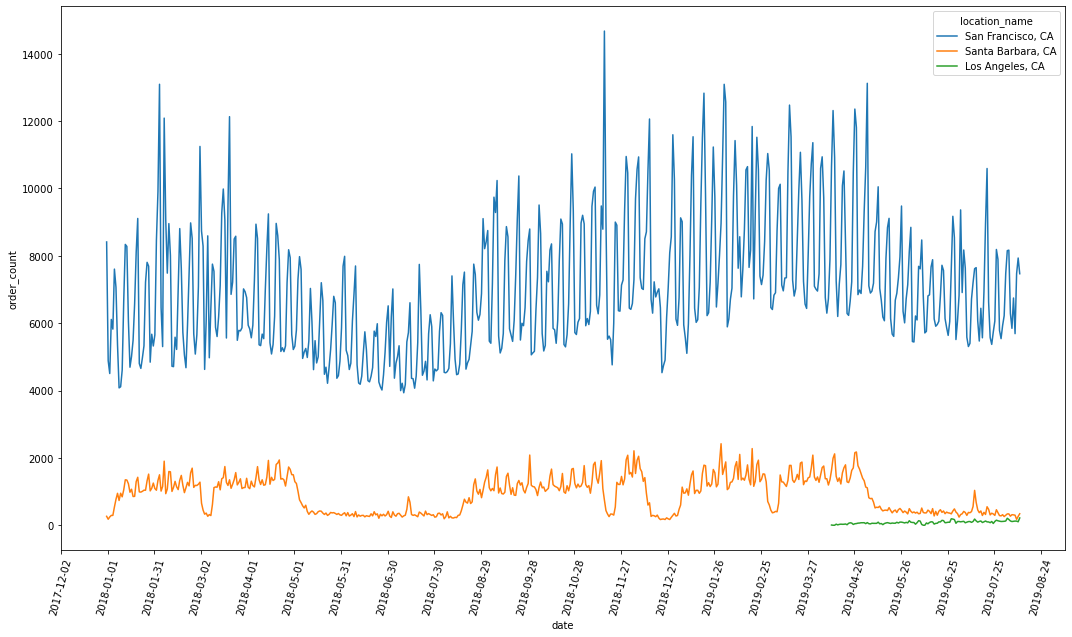

In [94]:
# Let's do some exploratory analysis and plot time series data of order count for each location

fig = plt.figure(figsize=(18,10))

ax = sns.lineplot(x="date", y="order_count", hue="location_name", data=orders)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 30))
plt.xticks(rotation=75)
plt.show()

A few observations from the time series plot above. 

- The time series data for San Francisco, CA and Santa Barbara, CA locations are available for Jan, 2018 to Sep, 2019. However, Los Angeles data is only available for April, 2019 to Aug, 2019. It looks like the first order in Los Angeles was delivered in early April, 2019. 


- San Francisco has much higher order volume compared to Santa Barbara, CA and Los Angeles, CA. 


- The time series plot indicates seasonality / periodic fluctuations and high order volume on certain days like holidays around Thanksgiving. 

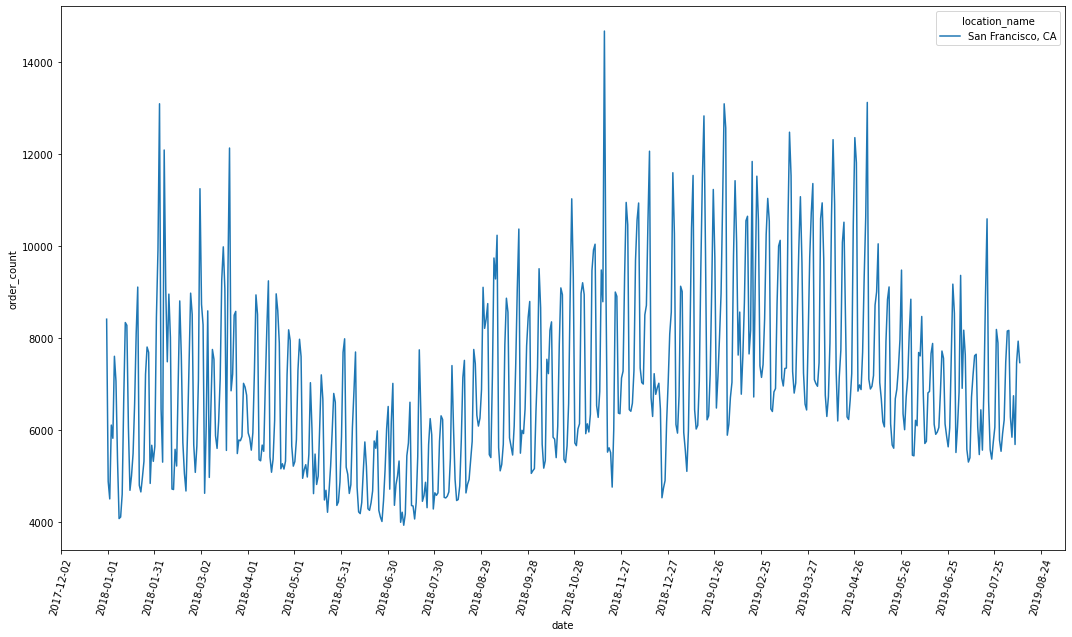

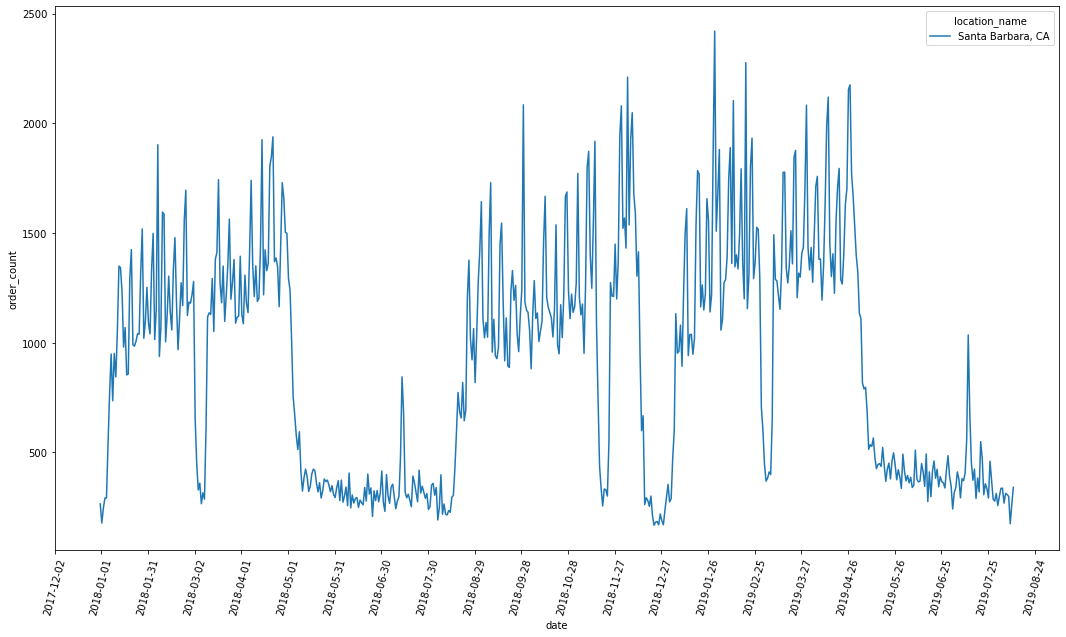

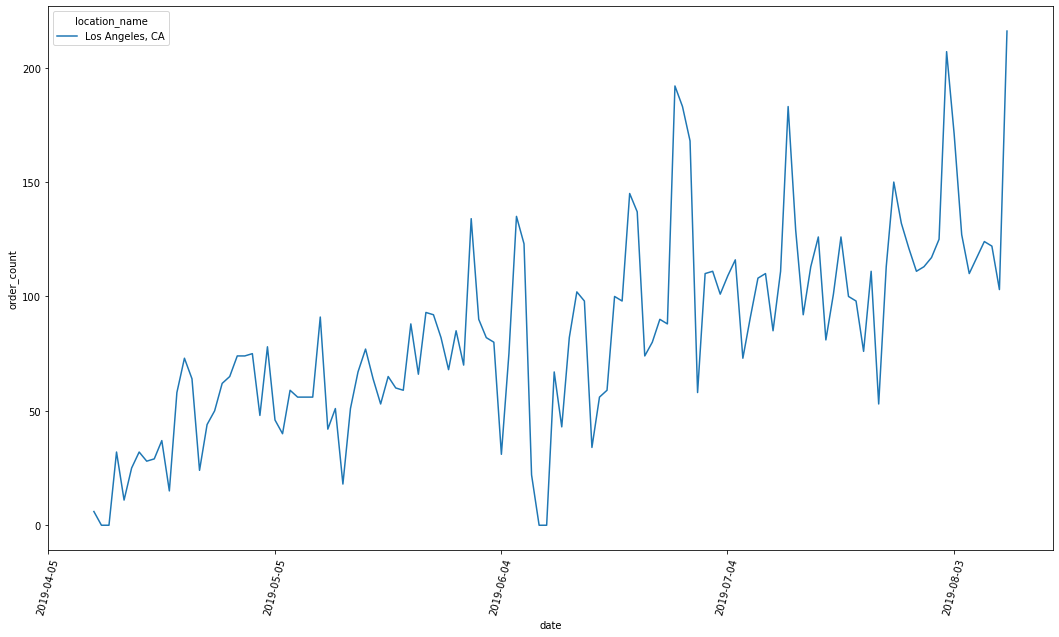

In [25]:
# Given the high variation in order volume between each location, let's plot each location seperately

locs = list(orders['location_name'].unique())

for loc in locs:
    
    # Filter DataFrame
    df = orders[orders['location_name'] == loc]
    
    fig = plt.figure(figsize=(18,10))

    ax = sns.lineplot(x="date", y="order_count", hue="location_name", data=df)

    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 30))
    plt.xticks(rotation=75)
    plt.show()
    


The above plots indicates the time series trend of order volume in each location. Upon further inspecting each series, it appears that there is weekly as well annual seasonality such as holiday effects. 

Order volume tends to be quite low around summer months. This is quite clear in Santa Barbara Location where order volume declines sharply during the months of May - August. The time series for SB looks like a Non - Stationary process.

### Let's decompose the time series to better understand the different components. 

In order to obtain / understand the true underlying trend, we need to seasonally adjust the data. Upon decomposing, we get the trend, seasonal and irregular / noise / random component. 

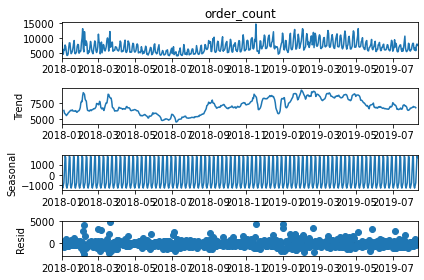

In [129]:
# Filter orders data for San Francisco, CA. We use additive model as variation appears to be relative constant for this location. 

order_sf = orders[orders['location_id'] == 6]

# Set date column as index
order_sf.set_index('date',inplace=True)

result = seasonal_decompose(order_sf['order_count'], model="additive")
resplot = result.plot()

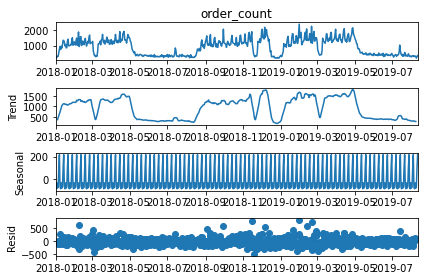

In [130]:
order_sb = orders[orders['location_id'] == 19]

# Set date column as index
order_sb.set_index('date',inplace=True)

result = seasonal_decompose(order_sb['order_count'], model="additive")
resplot = result.plot()

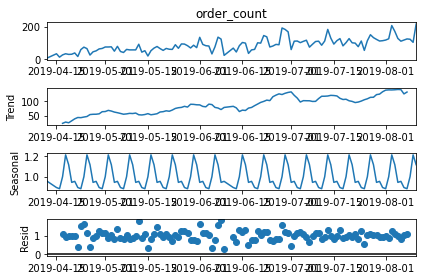

In [132]:
# Filter orders data for Los Angeles, CA. 
# We use multiplicative model as there appears to be a increasing trend for this location. 

order_la = orders[(orders['location_id'] == 114) & (orders['order_count'] > 0)]

# Set date column as index
order_la.set_index('date', inplace=True)

result = seasonal_decompose(order_la['order_count'], model="multiplicative", period = 7)
resplot = result.plot()

By seperating out different components of the time series, we get a clear view of the trend, periodicity and random components of the series. This helps inform our choice of model selection for forecasting task. 

The trend component in Los Angeles is increasing suggesting a multiplicative model would be a good choice. 

#### Autocorrelation and Partial Autocorrelation

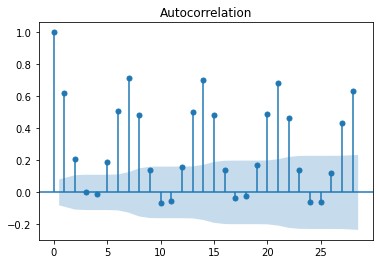

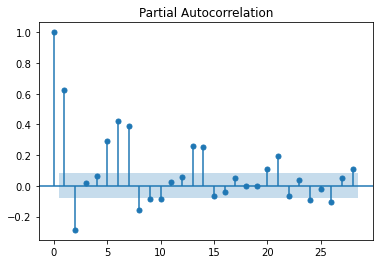

In [185]:
acf = plot_acf(order_sf['order_count'])
pacf = plot_pacf(order_sf['order_count'])

These plots help us analyze the correlation of the series with itself. On the x-axis, we have number of lags and y-axis is the pearson's correlation coefficient -1 to 1. 

From the plots, we see seasonal spikes at certain lags. Positive spikes are observed around 7, 14, 21 observation suggesting a weekly seasonal pattern.  

The time series data exhibits complex seasonal patterns - weekly & annual (holiday effects). Therefore, we need techniques that allow us to model these complex patterns. 

One of the tools that available to handle complex patterns and model them is Prophet: https://facebook.github.io/prophet/. We'll use the technique to forecast order count as it provides us the flexibility to specify multiple seasonal patterns and add regressor variables which would helpful in our case. 

We'd want to treat Los Angeles location separately, as we do not have enough observations to specify annual seasonality.

In [297]:
# Let's define prophet function to which we'll pass a dataframe

def prophet_forecast(df, loc):
    
    
    # Instantiate Prophet object
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    model.fit(df)

    # Let's forecast
    future = model.make_future_dataframe(periods = 14)  
    forecast = model.predict(future)
    
    # Plot forecast
    plot1 = model.plot(forecast)
    ax = plot1.gca()
    ax.set_title("Location {}:".format(loc))
    
    #plot2 = model.plot_components(forecast)
    
    # Cross - validate
    df_cv = cross_validation(model, initial='530 days', horizon = '14 days')
    
    df_p = performance_metrics(df_cv)
    
    # Performance metric plot
    plot3 = plot_cross_validation_metric(df_cv, metric='mape')
    
    return ({'table': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(14), 'plot1': plot1, 'plot3': plot3})

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 7 forecasts with cutoffs between 2019-06-16 00:00:00 and 2019-07-28 00:00:00


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 7 forecasts with cutoffs between 2019-06-16 00:00:00 and 2019-07-28 00:00:00


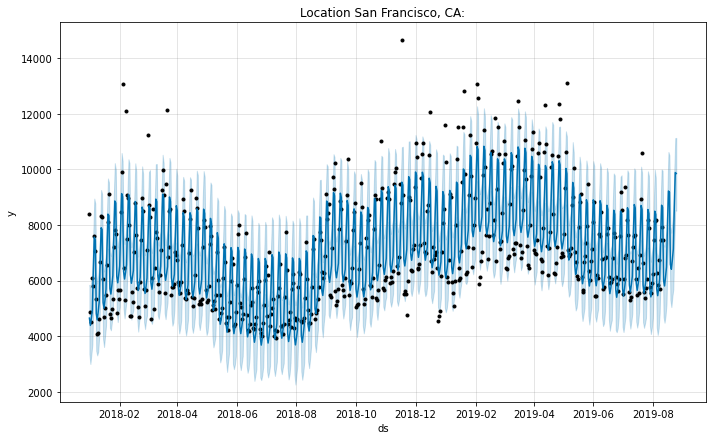

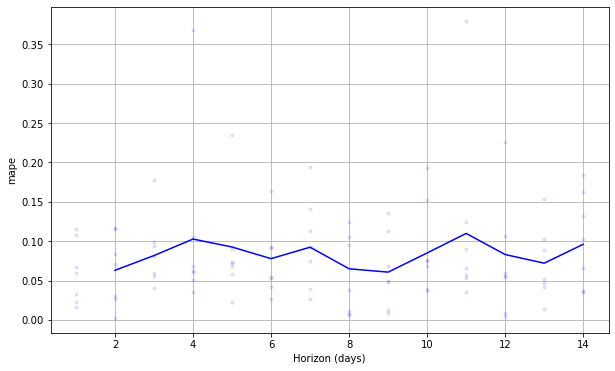

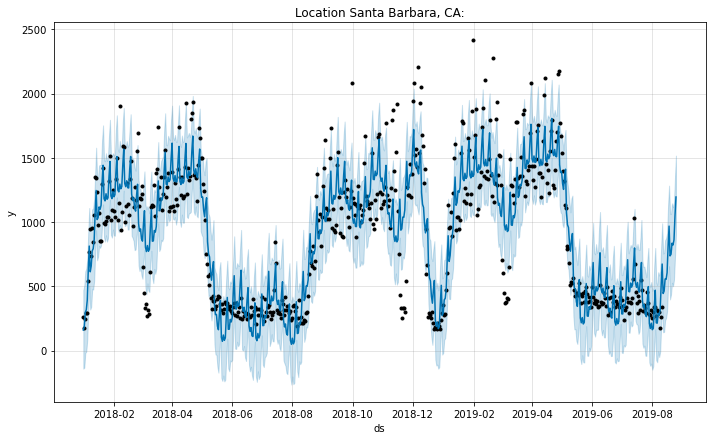

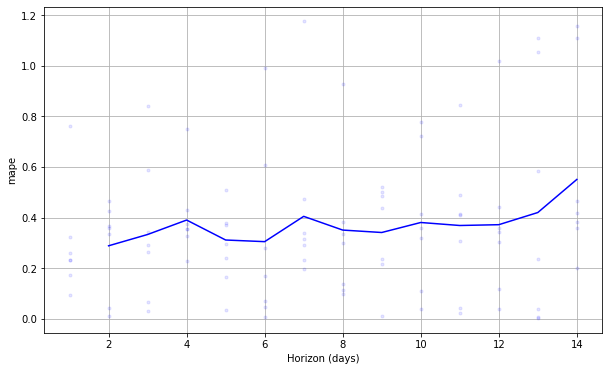

In [298]:
# Let's prepare our dataset for forecasting with Prophet

# We fit prophet model for San Francisco and Santa Barbara
locs = ['San Francisco, CA', 'Santa Barbara, CA']

for loc in locs:
    
    df = orders[orders['location_name'] == loc]

    df.rename({'date':'ds','order_count':'y'}, axis=1, inplace=True)

    res = prophet_forecast(df[['ds','y']], loc)
    
    

Key Findings and Recommendations for further model improvement: 
    
1. Based on the our observations of the data, we notice weekly and annual seasonal patterns. Order volume tends to be quite high over the weekends, around holidays and low during summer months of May - Aug. 
    
    
2. We run seasonal decomposition and plot Autocorrelation to get a clear understanding of different components and validate the seasonal patterns. 
    
    
3. As for model selection, we need a model that is flexible enough to model these trends / seasonal patterns as observed in the data for orders in San Francisco and Santa Barbara locations. There are likely some local effects for each location, and therefore, it would be best of us individually forecast for each location. 
    
    
4. We use Prophet, an technique that allows us to specify these complex multiple seasonal patterns and incorporate holiday effects into our model. 

5. Model diagnostics - cross-validation suggests that, while, our errors for San Francisco location are reasonable, performance is poor for Santa Barbara and there is room for model improvement. We may want to difference the time series to make it stationary / smooth the process and remove some of the noise, so that we can improve prediction accuracy. 
    

6. Residuals from decomposition plot suggests that there is randomness / noise in our data. In order to improve our prediction accuracy and capture some of the random component, we'd like to include additional variables such as:
    
        a. Weather related effects 
        b. Effects of promotions, advertising 
        c. Large events / gatherings, special events that could affect the demand 
        d. Location characteristics such as access / availability of substitutes, density of stores carrying    
           similar products, demographics etc. 
        
        
        
6. Other approaches. We could try a few different techniques and compare performance. One approach that we could try is Vector Autoregressive model (VAR) which allows us to use lagged values of itself and other time series variables.  

    
7. For Los Angeles location or generally other locations, where we do not have enough observations to specify annual seasonality yet, we could i) Either assume a similar trend to comparable location like San Francisco or ii) Fit the model with only weekly seasonality. Exponential smoothing approach could also be approriate in this case. 
    
For reference, 

https://otexts.com/fpp2/complexseasonality.html 

https://otexts.com/fpp2/expsmooth.html